# Logfile parsing
(back to overview [offline](../Main.ipynb),[online](https://nbviewer.jupyter.org/github/QCoDeS/Qcodes/tree/master/docs/examples/Main.ipynb))

[read on nbviewer](https://nbviewer.jupyter.org/github/QCoDeS/Qcodes/tree/master/docs/examples/logging/logfile_parsing.ipynb)

Here, we provide an example concerning how to benefit from QCoDeS logs by simple analysis and visualisation.

In [1]:
%matplotlib inline
import dateutil
import os

import pandas as pd
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes.logger.log_analysis import logfile_to_dataframe, time_difference, log_to_dataframe
from zipfile import ZipFile


Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/210108-25980-qcodes.log


In [2]:
# put the 30MB into a zip file
filepath = os.path.join(os.getcwd(), 'static', 'pythonlog.zip')
with ZipFile(filepath) as z:
    with z.open('pythonlog.log', 'r') as f:
        my_log = [line.decode() for line in f]

In [3]:
os.path.exists(filepath)

True

In [4]:
logdata = log_to_dataframe(my_log, separator=' - ', columns=['time', 'module', 'function', 'loglevel', 'message'])

The `logdata` is, now, a nice and tidy `DataFrame` that one can further manipulate to extract more information, if needed.

In [5]:
logdata

,time,module,function,loglevel,message
0,"2018-05-10 16:01:50,497",qcodes.instrument_drivers.QDev.QDac_channels,write,DEBUG,Writing to instrument qdac: wav 2 0 0 0;set 2 ...
1,"2018-05-10 16:01:50,546",qcodes.instrument.visa,ask_raw,DEBUG,Querying instrument SR860_120: OUTP? 2\r\n
2,"2018-05-10 16:01:50,552",qcodes.instrument.visa,ask_raw,DEBUG,Got response from instrument SR860_120: 8.9832...
3,"2018-05-10 16:01:50,553",qcodes.instrument.visa,ask_raw,DEBUG,Querying instrument SR860_120: SLVL?\r\n
4,"2018-05-10 16:01:50,561",qcodes.instrument.visa,ask_raw,DEBUG,Got response from instrument SR860_120: 9.9999...
...,...,...,...,...,...
255146,"2018-05-10 17:12:03,208",qcodes.instrument.visa,ask_raw,DEBUG,Querying instrument SR860_120: OUTP? 2\r\n
255147,"2018-05-10 17:12:14,257",qcodes.data.data_set,finalize,DEBUG,Finalising the DataSet. Writing.\r\n
255148,"2018-05-10 17:12:14,258",qcodes.data.gnuplot_format,write,DEBUG,Attempting to write the following group: qdac_...
255149,"2018-05-10 17:12:14,259",qcodes.data.gnuplot_format,write,DEBUG,Wrote to file from 40200 to 40201\r\n


In [6]:
data = logdata

### Get the query time for the SR860

We know that the log file documents an experiment quering an SR860 for R and amplitude over and over. Let us analyse and visualise query response times.

In [7]:
qstr_R = 'Querying instrument SR860_120: OUTP\? 2'  # remember to escape
queries_R = data[data.message.str.contains(qstr_R)]
responses_R = data.loc[queries_R.index + 1]

qstr_lvl = 'Querying instrument SR860_120: SLVL\?'  # remember to escape
queries_lvl = data[data.message.str.contains(qstr_lvl)][:-1]
responses_lvl = data.loc[queries_lvl.index + 1]

### Find the elapsed times

In [8]:
elapsed_times_R = time_difference(queries_R.time, responses_R.time)
elapsed_times_lvl =  time_difference(queries_lvl.time, responses_lvl.time)

## Visualise!

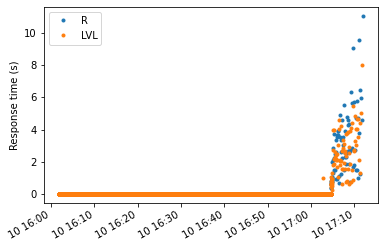

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(1,1)
ax.plot(queries_R.time.str.replace(',', '.').astype("datetime64[ns]"), elapsed_times_R, '.', label='R')
ax.plot(queries_lvl.time.str.replace(',', '.').astype("datetime64[ns]"), elapsed_times_lvl, '.', label='LVL')
fig.autofmt_xdate()
ax.set_ylabel('Response time (s)')
plt.legend()